# Build a decision tree


For this activity, we work as a consultant for an airline. The airline is interested in predicting whether a future customer would be satisfied with their services given customer feedback given previous customer feedback about their flight experience. The airline would like you to construct and evaluate a model that can accomplish this goal. Specifically, they are interested in knowing which features are most important to customer satisfaction.

The data for this activity includes survey responses from 129,880 customers. It includes data points such as class, flight distance, and in-flight entertainment, among others. In a previous activity, we utilized a binomial logistic regression model to help the airline better understand this data. In this activity, the goal will be to utilize a decision tree model to predict whether or not a customer will be satisfied with their flight experience. 

Let's get started

In [3]:
# Import the required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [4]:
# Load the dataset
df_original= pd.read_csv(r'C:\Users\user\Desktop\Course 5\Invistico_Airline.csv')

In [8]:
# Check first few rows
df_original.head(n=5)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


In [9]:
# Check basic info about the data.
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

In [12]:
### YOUR CODE HERE ###

df_original["Class"].value_counts()

Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64

**Quick Insight**

There are more people that boarded flight in the business class, than the economic and economic plus classes respectively.

In [21]:
# Check the classs balance for the outcome variable("Satisfaction")
print(df_original['satisfaction'].value_counts())

# Check the percentage of satisfied and dissatisfied customers
print(df_original['satisfaction'].value_counts(normalize= True)*100)

satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64
satisfied       54.73283
dissatisfied    45.26717
Name: satisfaction, dtype: float64


**Quick Insight**

There are 71087 satisfied customers and 58793 dissatisfied customers.
54.7% of customers were satisfied, while 45.3% were dissatisfied.This value can be compared to a decision tree's model accuracy.

 The class balance is good, as is it hard to get a 50:50 balance in a dataset. Therefore, we will not be balancing the class during this activity.

#### Check for missing values in the rows of the data. 
The sklearn decision tree implementation does not support missing values. 

In [25]:
# Check for missing values 
df_original.isnull().sum()

satisfaction                           0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

 **Note:** 

We will be dropping the rows with null values, as it contains a small % of the total number of rows. we have `0.303%` of null. Therfore we consider it safe to drop the rows containing null values.

In [46]:
# Make a copy of the original df, assigning it to a variable `df_subset`
df_subset= df_original.copy()

# Drop the null rows in df_subset
df_subset=df_subset.dropna(axis= 0).reset_index(drop=True)

# Check that the null values were dropped
df_subset.isna().sum()

satisfaction                         0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

### Encode the data

Four columns (`satisfaction`, `Customer Type`, `Type of Travel`, `Class`) are the pandas dtype object. Decision trees need numeric columns. Start by converting `Class` column into numeric. 

In [48]:
df_subset['Class'] = df_subset['Class'].map({"Business": 3, "Eco Plus": 2, "Eco": 1}) 

### Represent the data in the target variable numerically

To represent the data in the target variable numerically, assign `"satisfied"` to the label `1` and `"dissatisfied"` to the label `0` in the `satisfaction` column. 

In [49]:
df_subset['satisfaction'] = df_subset['satisfaction'].map({"satisfied": 1, "dissatisfied": 0})

In [50]:
df_subset.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,Loyal Customer,65,Personal Travel,1,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,1,Loyal Customer,47,Personal Travel,3,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,1,Loyal Customer,15,Personal Travel,1,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,1,Loyal Customer,60,Personal Travel,1,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,1,Loyal Customer,70,Personal Travel,1,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


### Convert categorical columns into numeric

There are other columns in the dataset that are still categorical. We will convert all the categorical variables to numeric ones.

In [51]:
df_subset= pd.get_dummies(df_subset, drop_first= True)

In [52]:
# Check the column data types
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129487 non-null  int64  
 1   Age                                129487 non-null  int64  
 2   Class                              129487 non-null  int64  
 3   Flight Distance                    129487 non-null  int64  
 4   Seat comfort                       129487 non-null  int64  
 5   Departure/Arrival time convenient  129487 non-null  int64  
 6   Food and drink                     129487 non-null  int64  
 7   Gate location                      129487 non-null  int64  
 8   Inflight wifi service              129487 non-null  int64  
 9   Inflight entertainment             129487 non-null  int64  
 10  Online support                     129487 non-null  int64  
 11  Ease of Online booking             1294

In [53]:
df_subset.head(3)

,satisfaction,Age,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,...,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Customer Type_disloyal Customer,Type of Travel_Personal Travel
0,1,65,1,265,0,0,0,2,2,4,...,3,0,3,5,3,2,0,0.0,0,1
1,1,47,3,2464,0,0,0,3,0,2,...,4,4,4,2,3,2,310,305.0,0,1
2,1,15,1,2138,0,0,0,3,2,0,...,3,3,4,4,4,2,0,0.0,0,1


## Create training and testing data

In [55]:
y=df_subset['satisfaction']

X= df_subset.copy()
X= X.drop('satisfaction', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X, y, stratify= y, test_size= 0.25, random_state= 0)

### Model building
#### Fit a decision tree classifier model to the data

In [56]:
# Instantiate a decision tree
decision_tree= DecisionTreeClassifier(random_state= 0)

# Fit it to the training data
decision_tree.fit(X_train, y_train)

# Predict the test data
dt_pred= decision_tree.predict(X_test)

### Note:

Decision trees require no assumptions regarding the distribution of underlying data and don't require scaling of features. This lab uses decision trees because there is no need for additional data processing, unlike some other models. 

### Result and evaluation

In [57]:
### YOUR CODE HERE ###

print("Decision Tree")
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Decision Tree
Accuracy: 0.933
Precision: 0.937
Recall: 0.942
F1 Score: 0.939


### Note:
Decision trees can be particularly susceptible to `overfitting`. Combining `hyperparameter tuning` and `grid search` can help ensure this doesn't happen. For instance, setting an appropriate value for max depth could potentially help reduce a decision tree's overfitting problem by limiting how deep a tree can grow. 

## Produce a confusion matrix

In [ ]:
cm= metrics.confusion_matrix(y_yest, dt_pred, labels= decision_tree.classes_)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= decision_tree.classes_)
disp.plot()
plt.show()

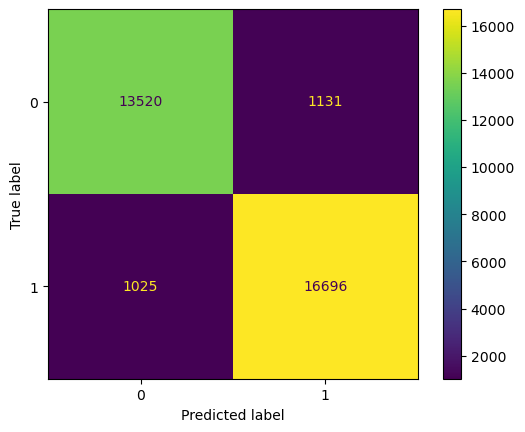

In [60]:
### YOUR CODE HERE ###

cm = metrics.confusion_matrix(y_test, dt_pred, labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)
disp.plot()
plt.show()

**Quick Insight:**

In the confusion matrix, there are a high proportion of true positives and true negatives (where the matrix accurately predicted that the customer would be satisfied or dissatified, respectively). 

The matrix also had a relatively low number of false positives and false negatives (where the matrix innacurately predicted that the customer would be satisfied or dissatified, respectively.) 

## Plot the  decision tree

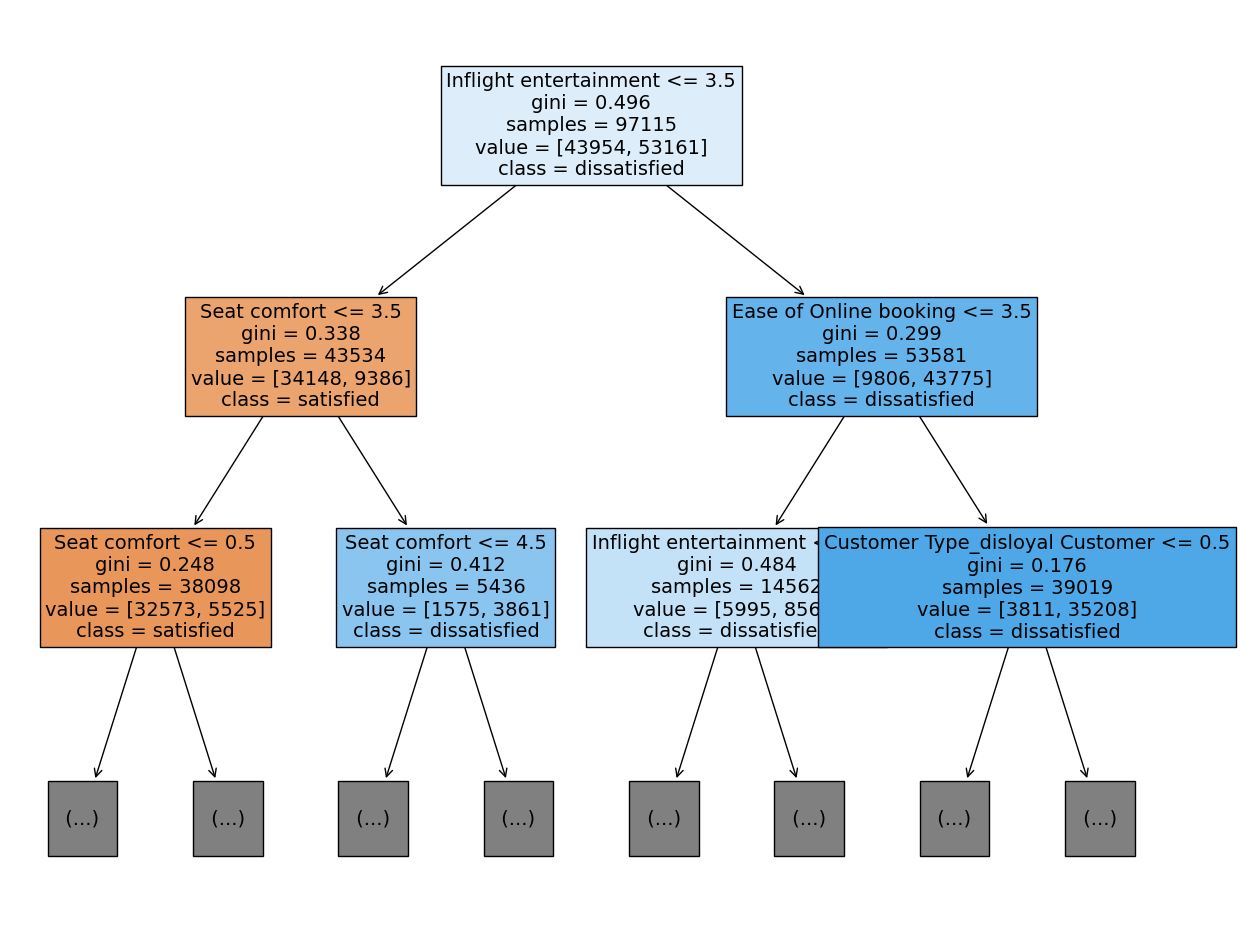

In [74]:
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, filled=True, fontsize=14,
          class_names= {0:'satisfied', 1:'dissatisfied'}, feature_names=X.columns)
plt.show()

### Build a feature importance graph
Uncover which features might be most important to the decision tree model by building a feature importance graph. 

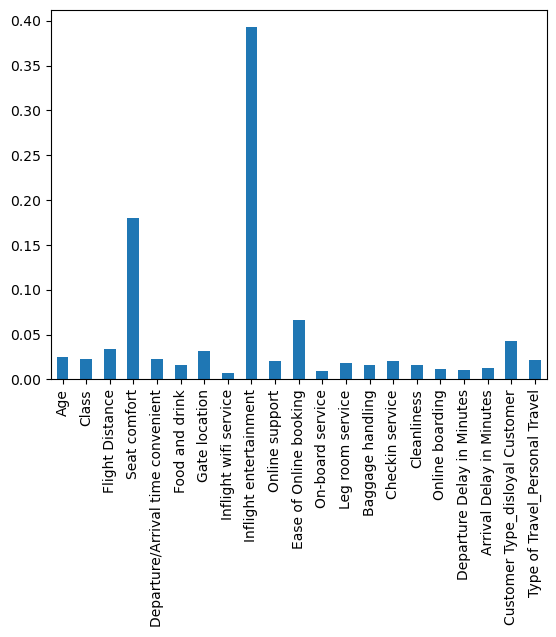

In [86]:
importances= decision_tree.feature_importances_

forest_importances= pd.Series(importances, index= X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

**Quick Insight**

The feature importance graph seems to confirm that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the most important features for this model. 

### Hyperparameter tuning

In this section, we will find the best values for the hyperparameters `max_depth` and `min_samples_leaf` using grid search and cross validation. Below are some values for the hyperparameters `max_depth` and `min_samples_leaf`.   

In [87]:
tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
             'min_samples_leaf': [1,2,3,4,5,6,7,8,9, 10, 15, 20, 50]}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

### Check combinations of values

Check every combination of values to examine which pair has the best evaluation metrics. Make a decision tree instance called `tuned_decision_tree` with `random_state=0`, make a `GridSearchCV` instance called `clf`, make sure to refit the estimator using `"f1"`, and fit the model on the training set. 

**Note:** This cell may take up to 15 minutes to run.

In [88]:
tuned_decision_tree= DecisionTreeClassifier(random_state=0)

clf= GridSearchCV(tuned_decision_tree,
                 tree_para,
                 scoring= scoring,
                 cv=5,
                 refit= 'f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 30, 40,
                                       50],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                              20, 50]},
             refit='f1', scoring={'accuracy', 'recall', 'f1', 'precision'})

**NOTE:**

Use the best estimator tool to help uncover the best pair combination. 

In [89]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=16, random_state=0)

**Quick Insight**

After running the DecisionTreeClassifier, the maximum depth is 16 and the minimum number of samples is two, meaning this is the best combination of values. 

### Determine the best average validation score

In [90]:
print("Best Avg. Validation Score: ", "%.3f" % clf.best_score_)

Best Avg. Validation Score:  0.944


**Quick Insight**
 
 The best validation score is 0.944

### Determine the "best" decision tree model's accuracy, precision, recall, and F1 score

Print out the decision tree model's accuracy, precision, recall, and F1 score.

In [91]:
results = pd.DataFrame(columns=['Model', 'F1', 'Recall', 'Precision', 'Accuracy'])

def make_results(model_name, model_object):
    """
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    """

    # Get all the results from the CV and put them in a df.
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score).
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row.
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create a table of results.
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                          'F1': f1,
                          'Recall': recall,
                          'Precision': precision,
                          'Accuracy': accuracy},
                         ignore_index=True)

    return table

result_table = make_results("Tuned Decision Tree", clf)

result_table

C:\Users\user\AppData\Local\Temp\ipykernel_7952\2625253063.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.944481,0.938225,0.950839,0.939618


**Quick Insight:**

The F1 score for the decision tree that was not hyperparameter tuned is 0.940940 and the F1 score for the hyperparameter-tuned decision tree is 0.945422. While ensuring that overfitting doesn't occur is necessary for some models, it didn't make a meaningful difference in improving this model. 

Any of the metrics in this business case could be considered important, depending on what the stakeholder or domain expert cares about. The following are reasons why each metric is important: 

- Accuracy tends to be the metric that the stakeholders can best understand.

- Precision measures what proportion of predicted positives is truly positive. For example, if we wanted to not falsely claim a customer is satisfied, precision would be a good metric.

- Recall measures the percentage of actual positives a model correctly identified (true positive). For this dataset, the airline might want to limit false negatives (actually satisfied people who are predicted to be unsatisfied). Assuming a customer is predicted to be unhappy when the customer is happy can lead to the airline wasting resources trying to improve the customer experience of an already happy customer. 

- F1 balances precision and recall. It is the harmonic mean of precision and recall, or their product divided by their sum.

# Considerations


**My findings to other data professionals**
*   Decision trees accurately predicted satisfaction over 94 percent of the time.  
*   The confusion matrix is useful as it shows a similar number of true positives and true negatives. 
*   The visualization of the decision tree and the feature importance graph both suggest that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the most important features in the model.

**My findings to stakeholders**
*  Customer satisfaction is highly tied to `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'`. Improving these experiences should lead to better customer satisfaction. 
*  The success of the model suggests that the airline should invest more effort into model building and model understanding since this model semed to be very good at predicting customer satisfaction. 